# Boundary to field inference with (and without) hypernetworks

We are studying the propagation of uncertainty from boundary conditions to (magnetic) field solutions within that boundary. As a starting point for our baseline, we are going to degrade the problem in three ways: i) we will study solutions from exact boundaries; ii) we will use the potential rather than the field; and iii) we will use of a circular (vs. square) boundary.

Of these, the last seems unimportant. Because our observations will be of the field, we will need to work back to a method that uses that rather than the potential, some other time. But propagation of uncertainly will have to be dealt with today.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa

## Example of potential and field contribution from boundary modes ('sources')

Our first insight is that, by definition, the scalar-valued potential on the boundary must be smooth*, real-valued and periodic (i.e. because it is a boundary).

*Here, smooth is to be understood as at least continuous, however unless some part of the boundary crosses the edge of a source it will be smooth in a stronger sense of continuously differentiable ($C^\infty$?) that we will use here.

Functions with these properties are expressible through a _discrete_ Fourier spectrum. Mapping the boundary (at normalised $r=1$) to the interval $\theta\in[0, 2\pi)$, we can write $$\phi(\theta) = \sum_{n=0}^\infty a_n \cos(n\theta) + b_n\sin(n\theta).$$ Moreover, when the boundary is a circle the solution (to the Laplace equation) inside the boundary is $$\phi(r, \theta) = \sum_{n=0}^\infty r^n \left[a_n \cos(n\theta) + b_n\sin(n\theta)\right].$$

This gives us a fast analytical generative recipe for studying boundary solutions: i) given a boundary function $f$, compute its discrete spectrum $(a_n, b_n)$ up to some order $n_\text{max}$; ii) generate the interior solutions to the Laplace equation as above. 

So let's do that now, picking the coefficients $(a_n, b_n)$ at random. In particular, we're going to vectorise over the modes (each value of $n$). Here's an example plot of a single mode on the boundary 'unwrapped' into the interval $[0, 2\pi)$:

In [2]:
def sph(x, y):
    return jnp.sqrt(x**2 + y**2), jnp.arctan2(y, x)


def cart(R, theta):
    return R * jnp.cos(theta), R * jnp.sin(theta)


def mode(n, r, theta):
    return jnp.stack([jnp.cos(n * theta) * r**n, jnp.sin(n * theta) * r**n])


@jax.jit
def potential(coeffs, p):
    r, theta = sph(*p)
    ks = jnp.arange(0, coeffs.size // 2)
    modes = jax.vmap(mode, (0, None, None))(ks, r, theta)
    return jnp.tensordot(modes, coeffs.T, axes=2)
    # return jnp.einsum("ij,ji->", modes, coeffs)


@jax.jit
def field(coeffs, p):
    return jax.grad(potential, argnums=1)(-coeffs, p)


total_potential = jax.vmap(potential, (None, 0))
total_field = jax.vmap(field, (None, 0))

In [108]:
n_modes = 1
res = 201
coeffs = jnp.array([0 for _ in range(7)] + [1.0])  # n = 7 mode only
coeffs = jnp.stack([coeffs, coeffs])
theta = jnp.linspace(-jnp.pi, jnp.pi, res)

dx, dy = cart(R=1, theta=theta)
dz = total_potential(coeffs, jnp.stack([dx, dy], axis=-1))

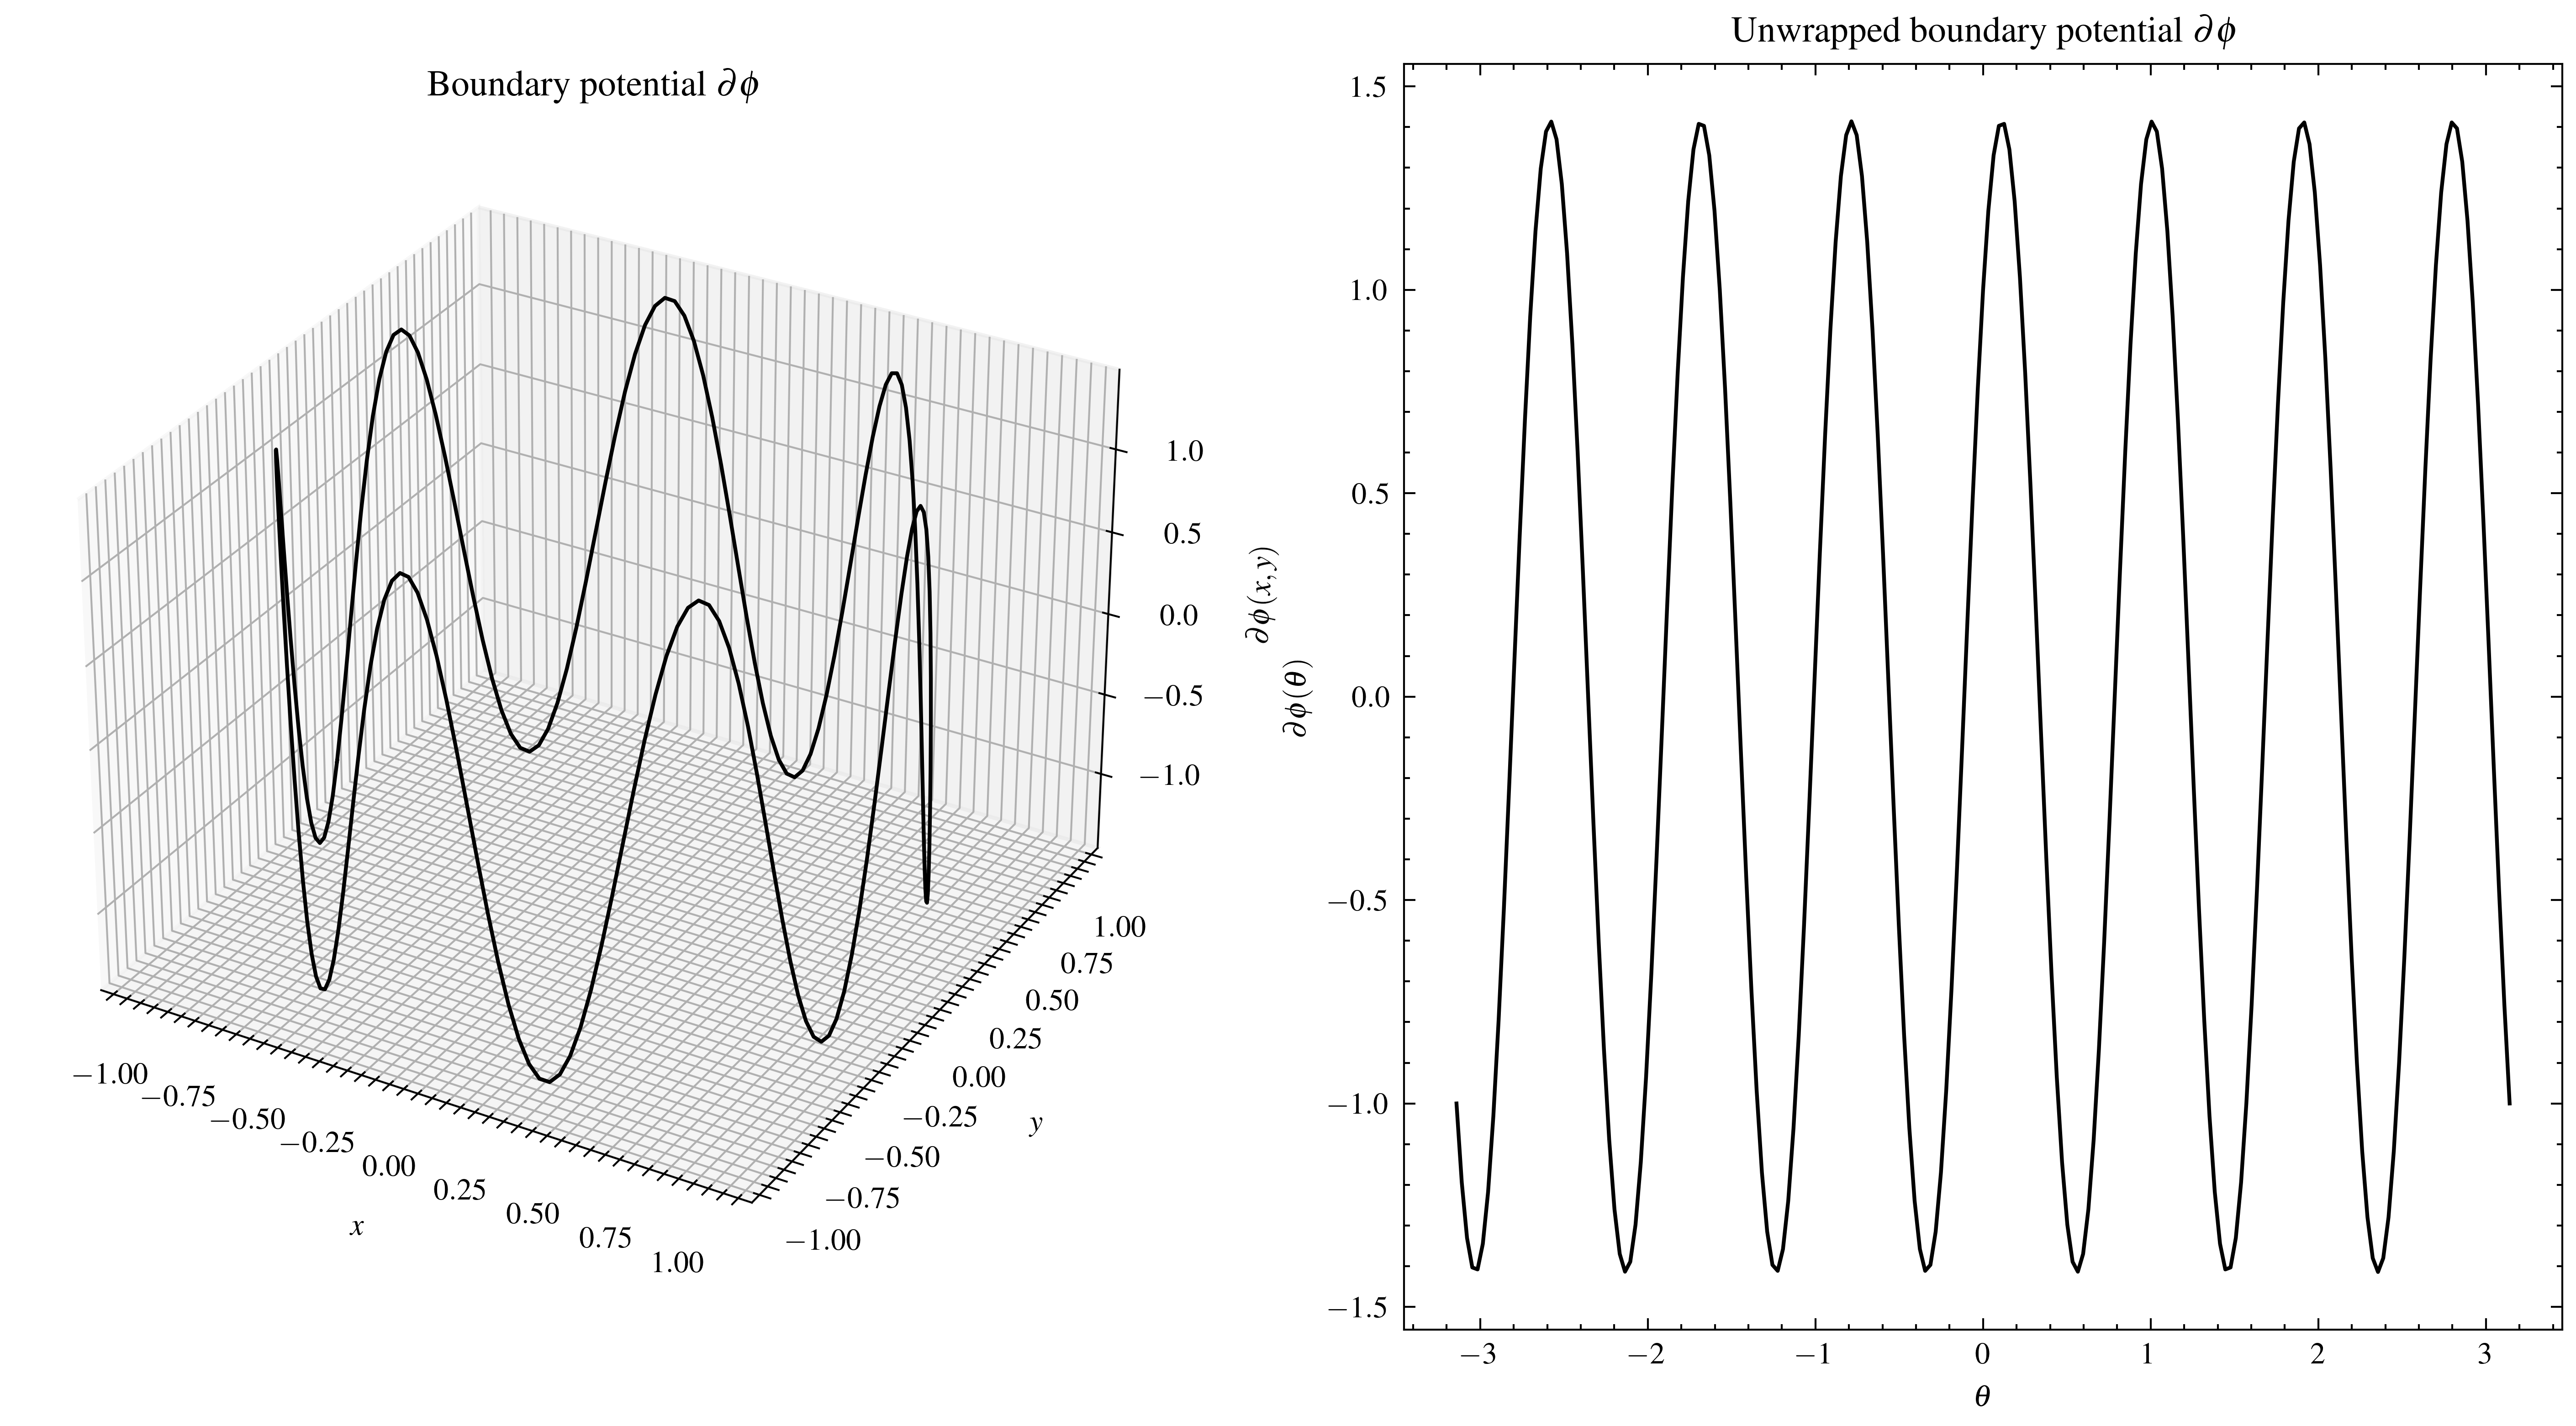

In [109]:
with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(12, 6))

    # Left subplot: 3D line plot
    ax1 = fig.add_subplot(121, projection="3d")
    ax1.plot(dx, dy, dz)
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    ax1.set_zlabel("$\partial\phi(x,y)$")
    ax1.set_title("Boundary potential $\partial\phi$")

    # Right subplot: 2D line plot
    ax2 = fig.add_subplot(122)
    ax2.plot(theta, dz)
    ax2.set_xlabel("$\\theta$")
    ax2.set_ylabel("$\partial\phi(\\theta)$")
    ax2.set_title("Unwrapped boundary potential $\partial\phi$")

    # plt.tight_layout()
    plt.show()

Now let's immediately work with a general boundary, generating the interior potential solution and the resulting field:

In [110]:
n_modes = 15  # n_coeffs = 2*n_modes + 1
coeffs = jr.normal(shape=(2, n_modes), key=jr.PRNGKey(res))
coeffs = coeffs.at[1, 0].set(0.0)  # n = 0 sin-mode is zero

dphi = total_potential(coeffs, jnp.stack([dx, dy], axis=-1))

x, y = jnp.meshgrid(jnp.linspace(-1, 1, res), jnp.linspace(-1, 1, res))
pts = jnp.stack([x, y], axis=-1).reshape(-1, 2)
phi = total_potential(coeffs, pts).reshape(res, res)
f = total_field(coeffs, pts).reshape(res, res, 2)
Bx = f[..., 0]
By = f[..., 1]

x, y, phi, Bx, By = np.array(x), np.array(y), np.array(phi), np.array(Bx), np.array(By)

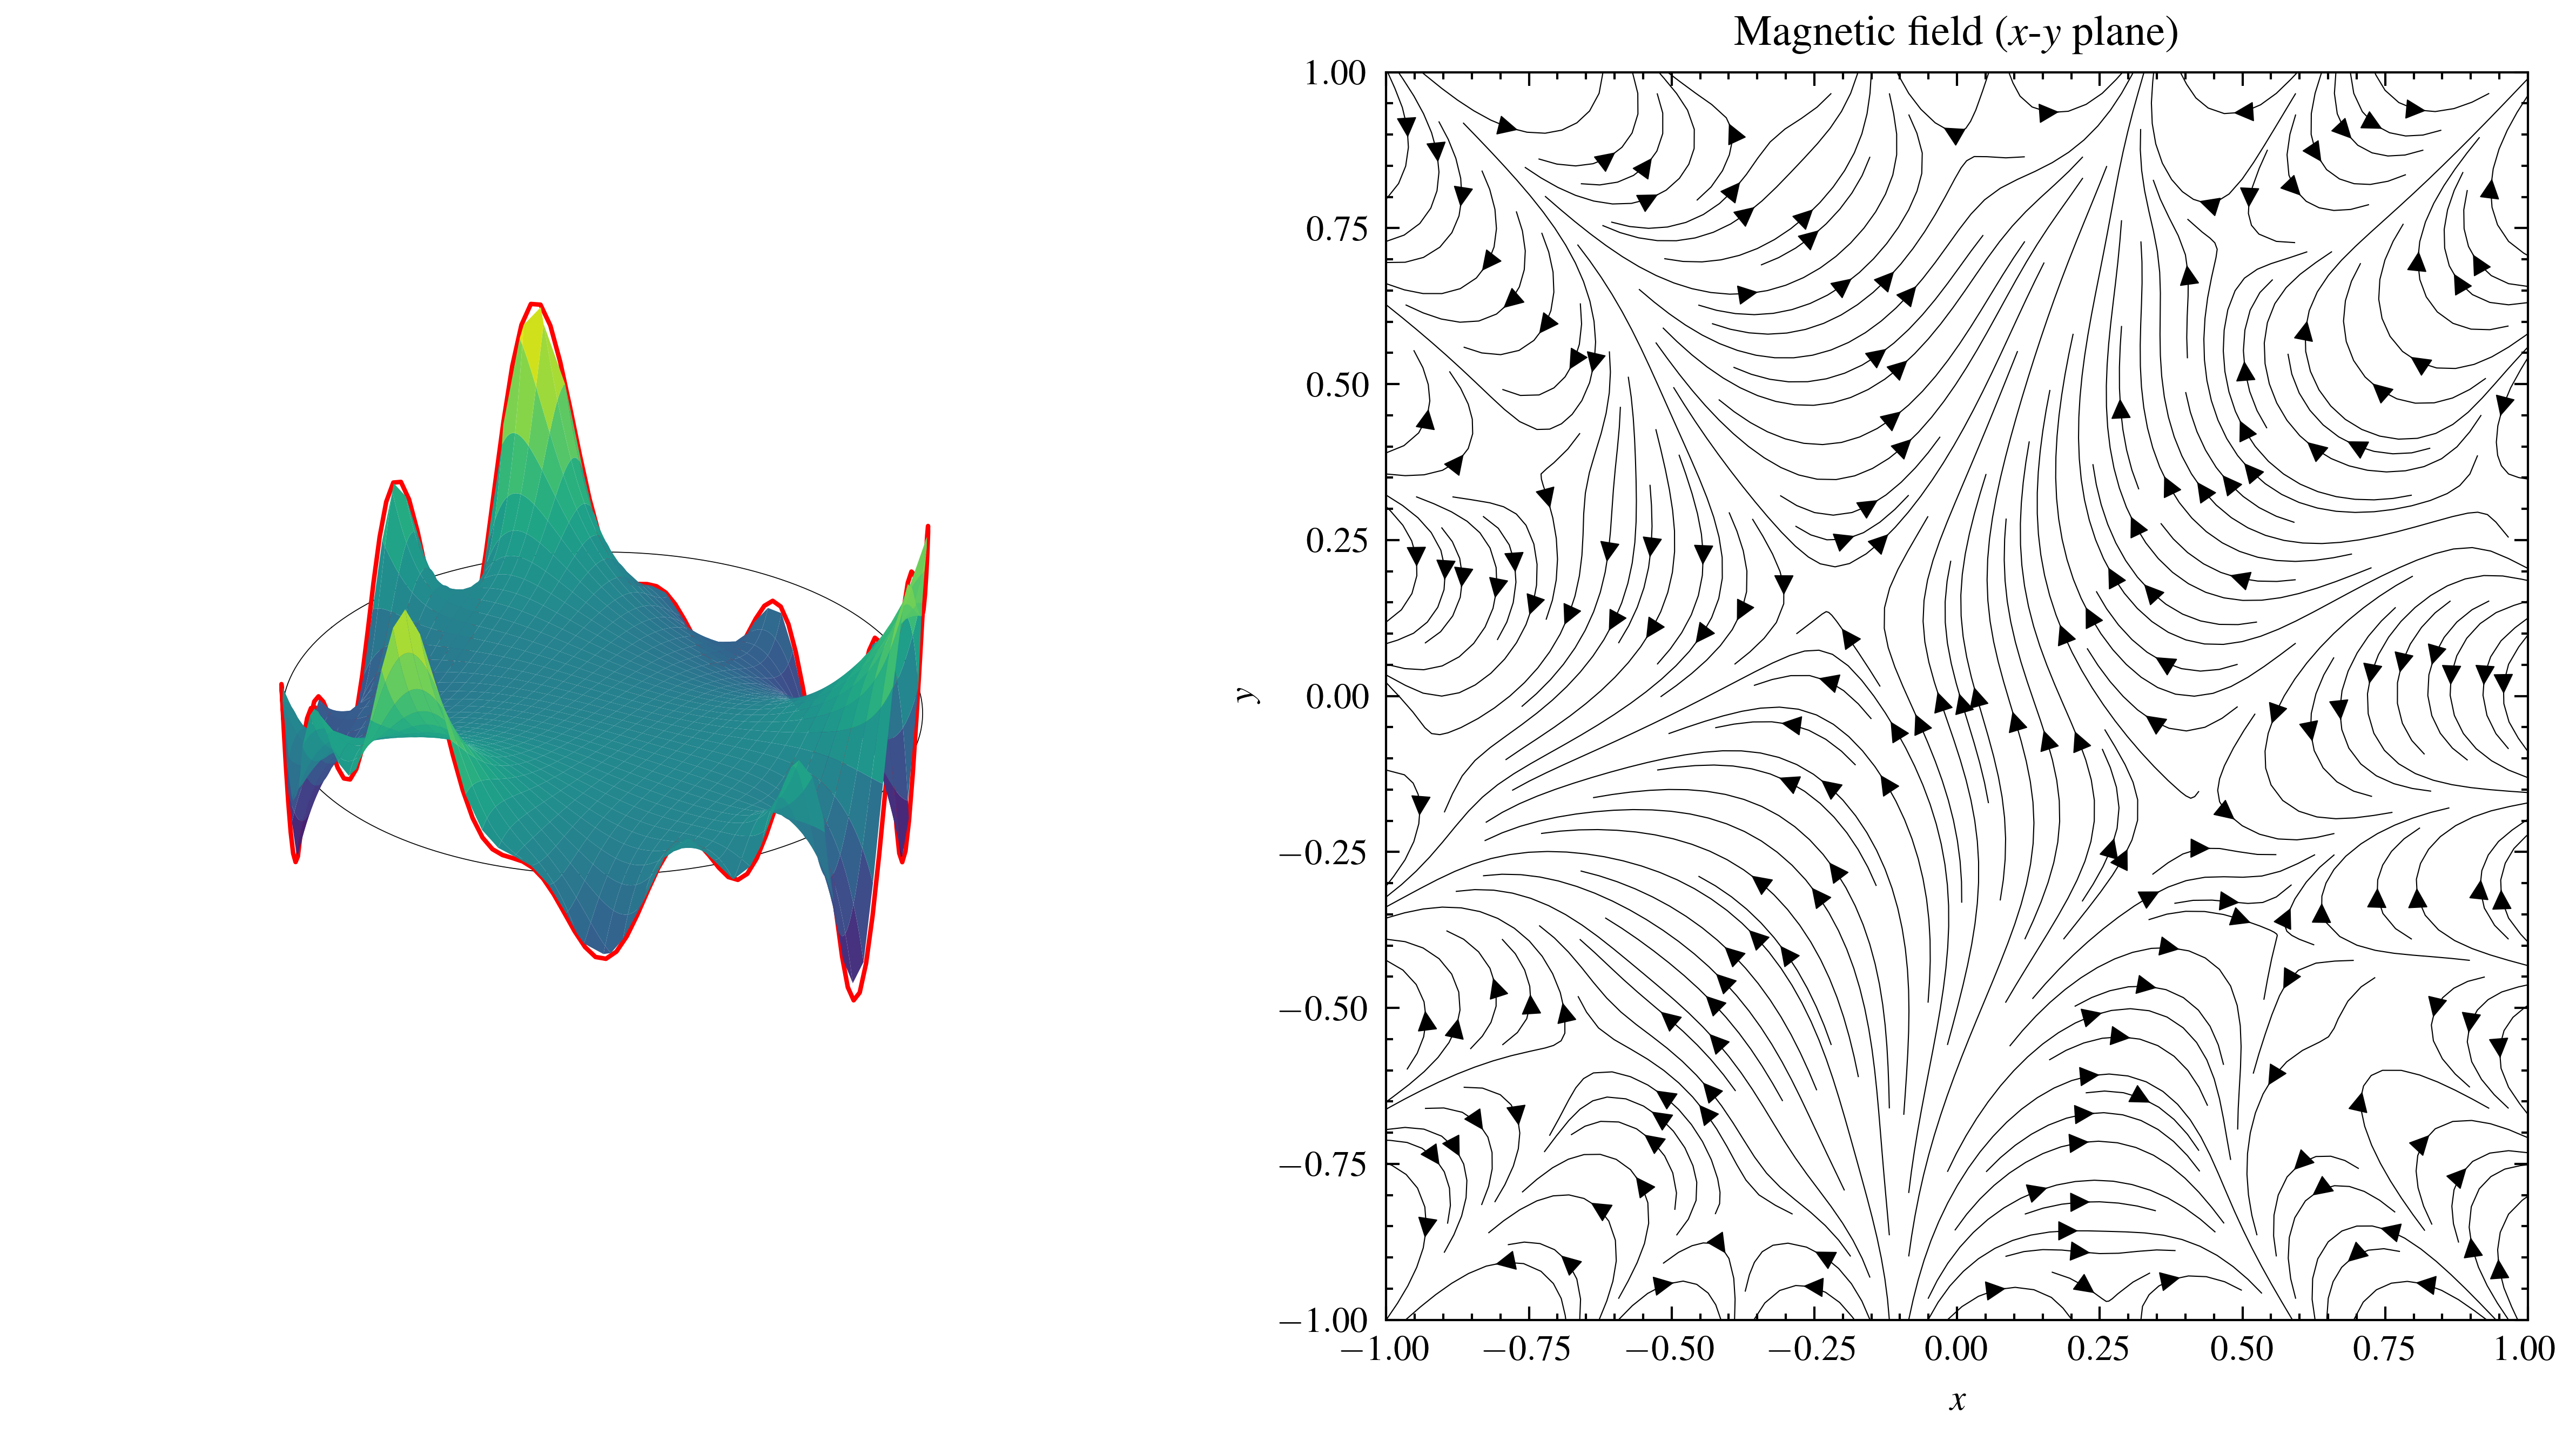

In [111]:
with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection="3d")

    # Prevent surface cells outside the radius from being plotted
    phi[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
    ax.plot_surface(x, y, phi, cmap="viridis", edgecolor="none")
    ax.axis("off")  # Hide the background 3D axis lines

    # Plot the reference circle at r = 1
    ax.plot(dx, dy, np.zeros_like(dx), color="black", linewidth=0.2)

    # Plot the Dircihlet boundary condition
    ax.plot(dx, dy, dphi, "r-", linewidth=1)

    # Associated magnetic field
    ax2 = fig.add_subplot(122)
    ax2.streamplot(x, y, Bx, By, color="black", linewidth=0.25, density=2)
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$y$")
    ax2.set_title("Magnetic field ($x$-$y$ plane)")

    plt.show()

(N.b. gaps at the edges between the boundary function (in red) and the interior solution surface are discretisation artefacts, not approximation error. Our solution is an exact generative model for all $(x,y)$ within the boundary and the mesh is simply for visualisation.)

## An interesting correspondence enabling a fast approximate solution

The baseline implementation above is the $\mathcal{O}(N_\text{max}\times\text{res}^2)$. It is interesting to note that the interior solutions to the Laplace equation satisfy _the principle of superposition_ with regard to the individual modes on the boundary. In this sense we can make the following correspondences:
$$
\begin{align}
&\text{single $n$ boundary mode} & \leftrightarrow\ & \text{individual `source' of $\phi$} \\
&\text{boundary function $f$} & \leftrightarrow\ & \text{source `collection' generating $\phi$} \\
&\text{Laplace solution $\nabla^2\phi = 0$} & \leftrightarrow\ & \text{potential $\phi$ generated by source collection} \\
\end{align}
$$

Having observed this, we can create a PINN that solves a given boundary potential $f$ using the methods from an exciting recent submission to ICML

<center><img src="assets/header.png" alt="Scalable source-to-field inference with hypernetworks" width="800px" /></center>

In this scheme, the PINN we develop is $\mathcal{O}(N_\text{max} + \text{res}^2)$, and $\text{---}$ unusally for a PINN $\text{---}$ provides a solution to the Laplace equation for _general_ boundary conditions without requiring retraining.

The start of this implementation is below. So far, I have just written the sampler for the training data to avoid overfitting from a grid.

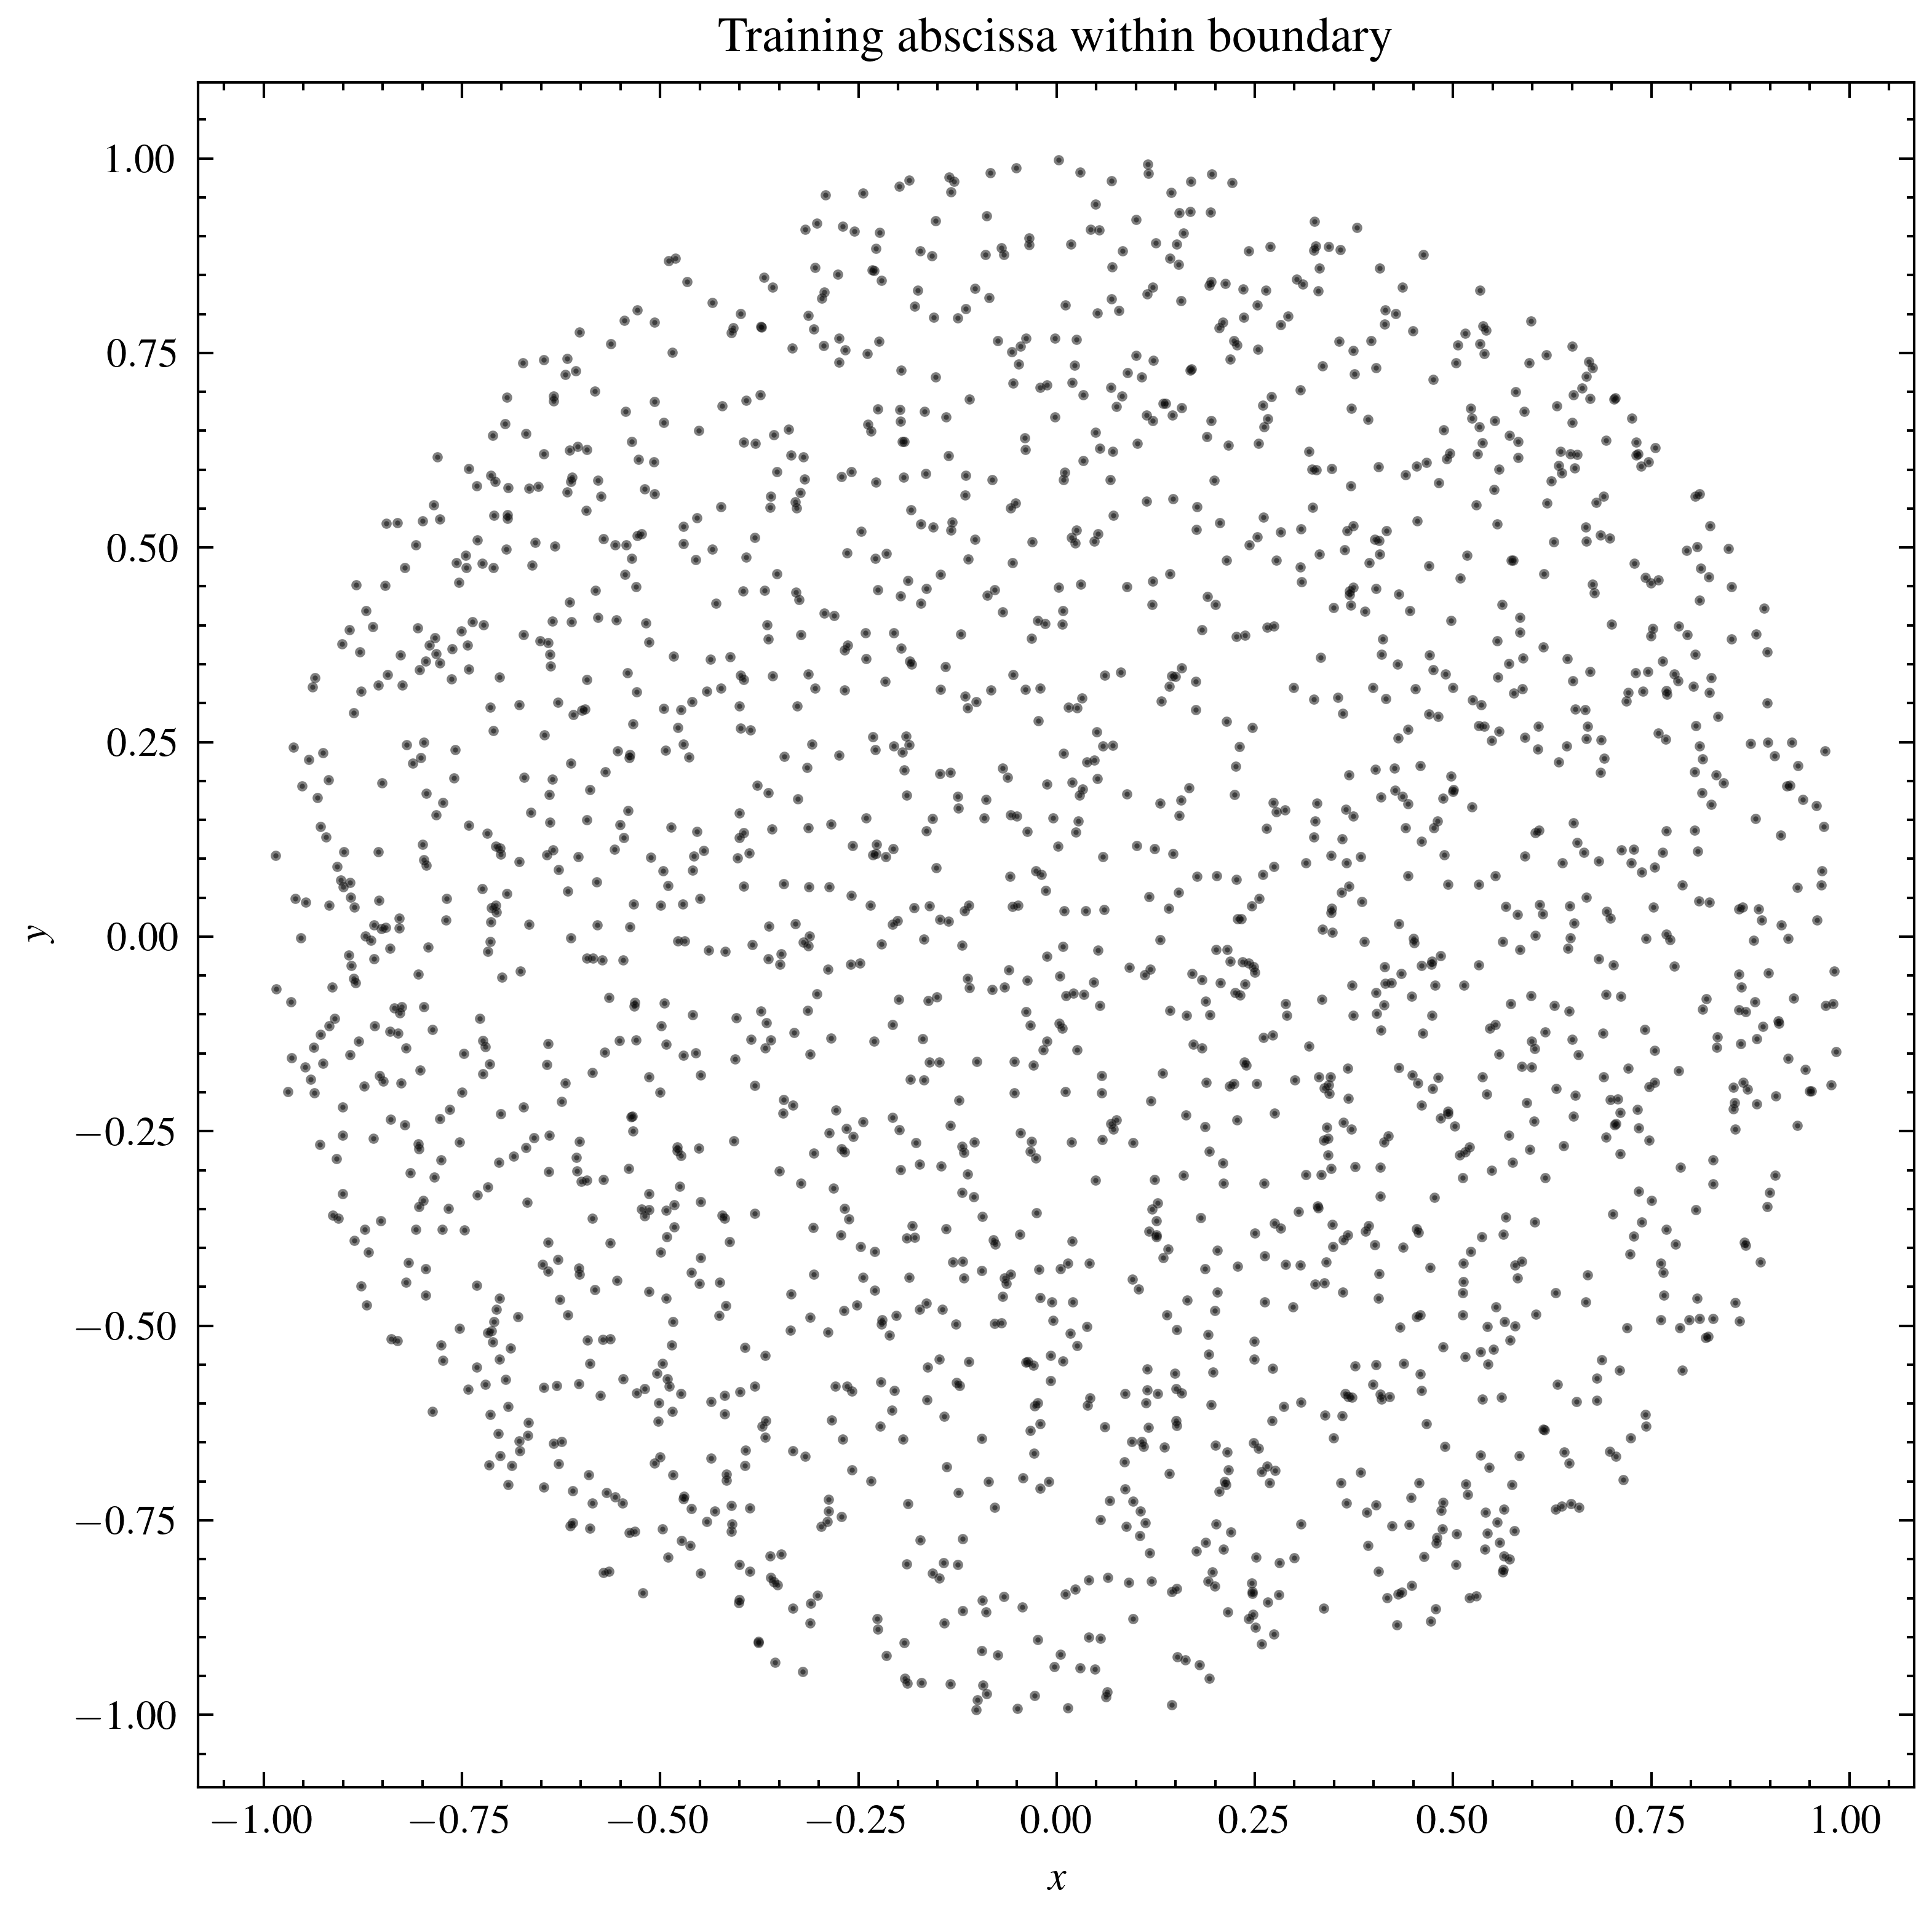

In [112]:
def sample_disc(N, seed=0):
    rkey, tkey = jr.split(jr.PRNGKey(seed))
    r = jnp.sqrt(jr.uniform(rkey, (N,)))
    theta = 2 * jnp.pi * jr.uniform(tkey, (N,))
    return cart(r, theta)


x, y = sample_disc(2000, seed=20)

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(x, y, color="black", s=1, alpha=0.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Training abscissa within boundary")
    plt.show()

## Periodic gaussian process for boundary data observations

Returning to our boundary condition $\partial\phi(\theta)\equiv f$, we now want to construct sampling process that generates complete boundaries from observed data. 

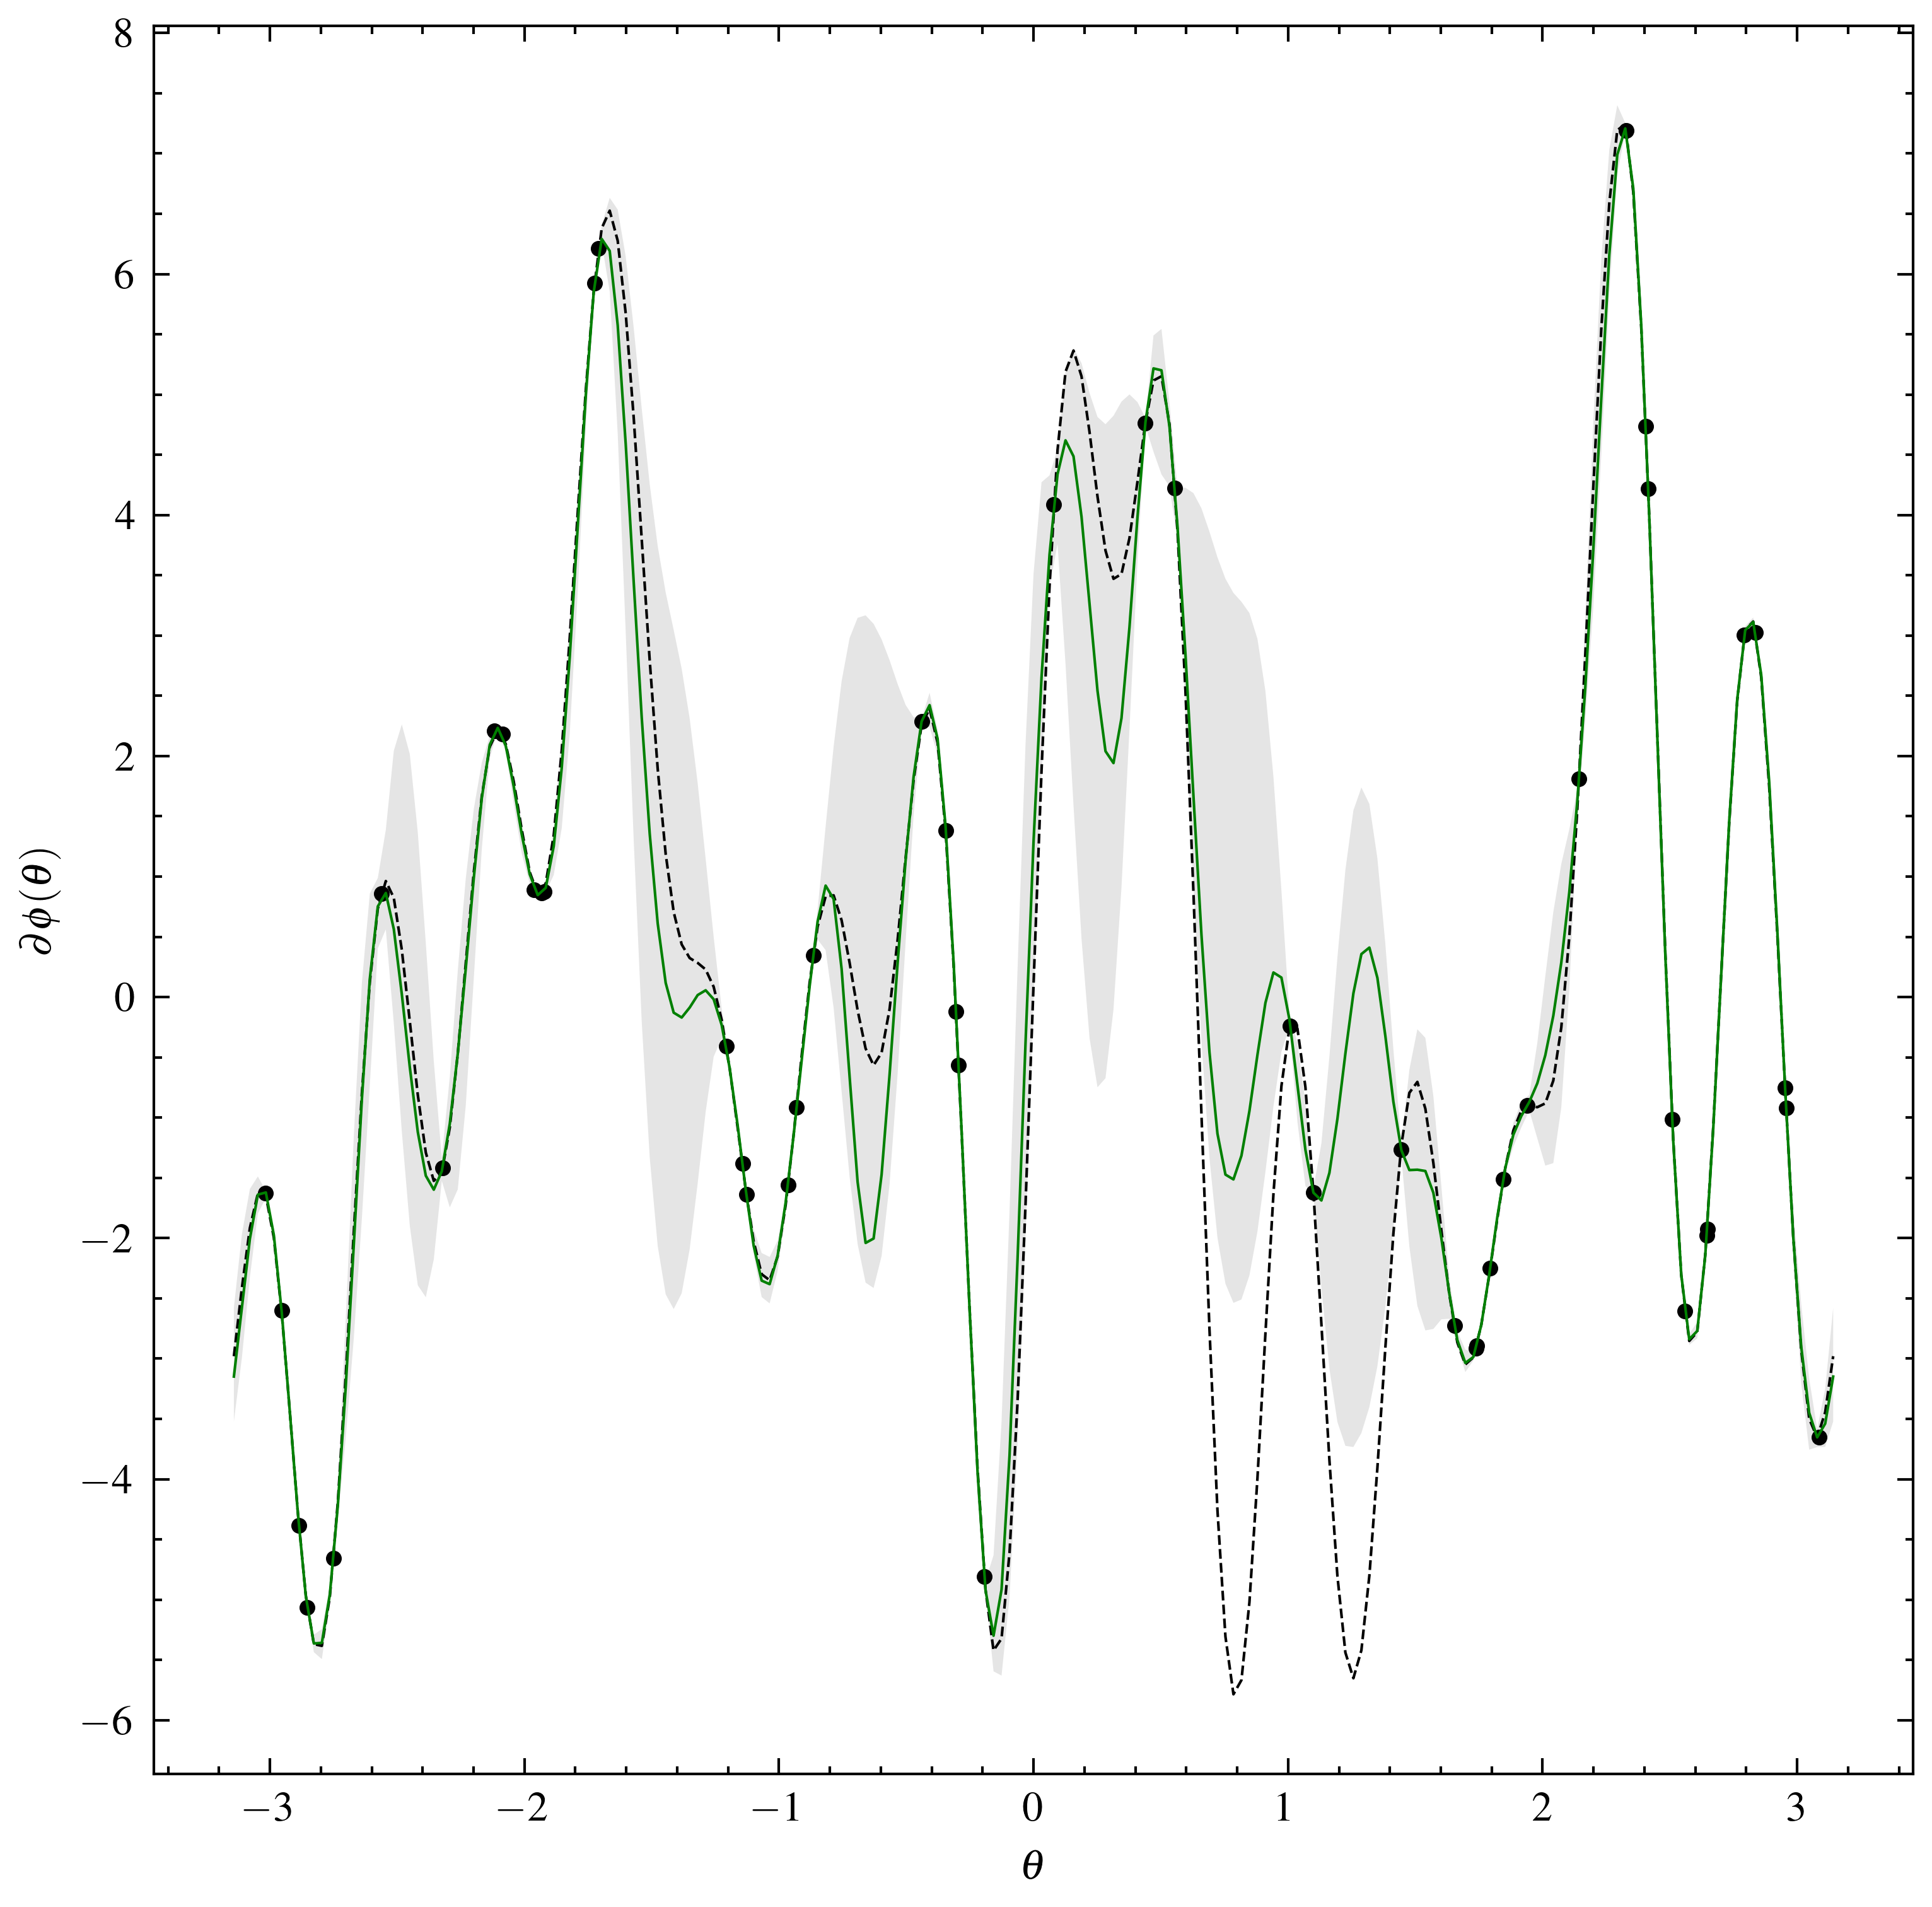

In [113]:
import time

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

N = 50
seed = int(time.time())
theta_obs = jr.uniform(key=jr.PRNGKey(seed), shape=(N,)).sort() * 2 * jnp.pi - jnp.pi
dphi_obs = (
    total_potential(coeffs, cart(1.0, theta_obs))
    + jr.normal(key=jr.PRNGKey(seed + 1), shape=(N,)) * 0.01
)
X, y = theta_obs.reshape(-1, 1), dphi_obs.reshape(-1, 1)

kernel = ExpSineSquared(
    length_scale=1, periodicity=2 * np.pi, periodicity_bounds="fixed"
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0001, n_restarts_optimizer=9).fit(
    X, y
)
mean_prediction, std_prediction = gpr.predict(theta.reshape(-1, 1), return_std=True)
sample = gpr.sample_y(theta.reshape(-1, 1), n_samples=1).ravel()

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(theta_obs, dphi_obs, "o", markersize=2)
    plt.plot(theta, dphi, color="black", linewidth=0.5)
    plt.plot(theta, sample, "g-", linewidth=0.5)
    plt.fill_between(
        theta.ravel(),
        mean_prediction - 3 * std_prediction,
        mean_prediction + 3 * std_prediction,
        alpha=0.1,
        label=r"95% confidence interval",
    )

    plt.xlabel("$\\theta$")
    plt.ylabel("$\partial\phi(\\theta)$")
    plt.show()

In [114]:
n_max = (
    len(sample) // 2 + 1
)  # Ensure n_max is correctly defined based on the sample length
F = np.fft.rfft(sample) / len(sample)
sample_coeffs = 2 * np.stack([np.real(F[:n_max]), -np.imag(F[:n_max])], axis=0)
sample_coeffs[0, 0] /= 2  # Correctly scale the DC component
sample_coeffs[:, 1::2] *= -1  # Adjust the sign for odd n components

if len(sample) % 2 == 0:  # Correctly scale the Nyquist frequency component if N is even
    sample_coeffs[0, -1] = F[-1].real / len(
        sample
    )  # No doubling for the Nyquist component

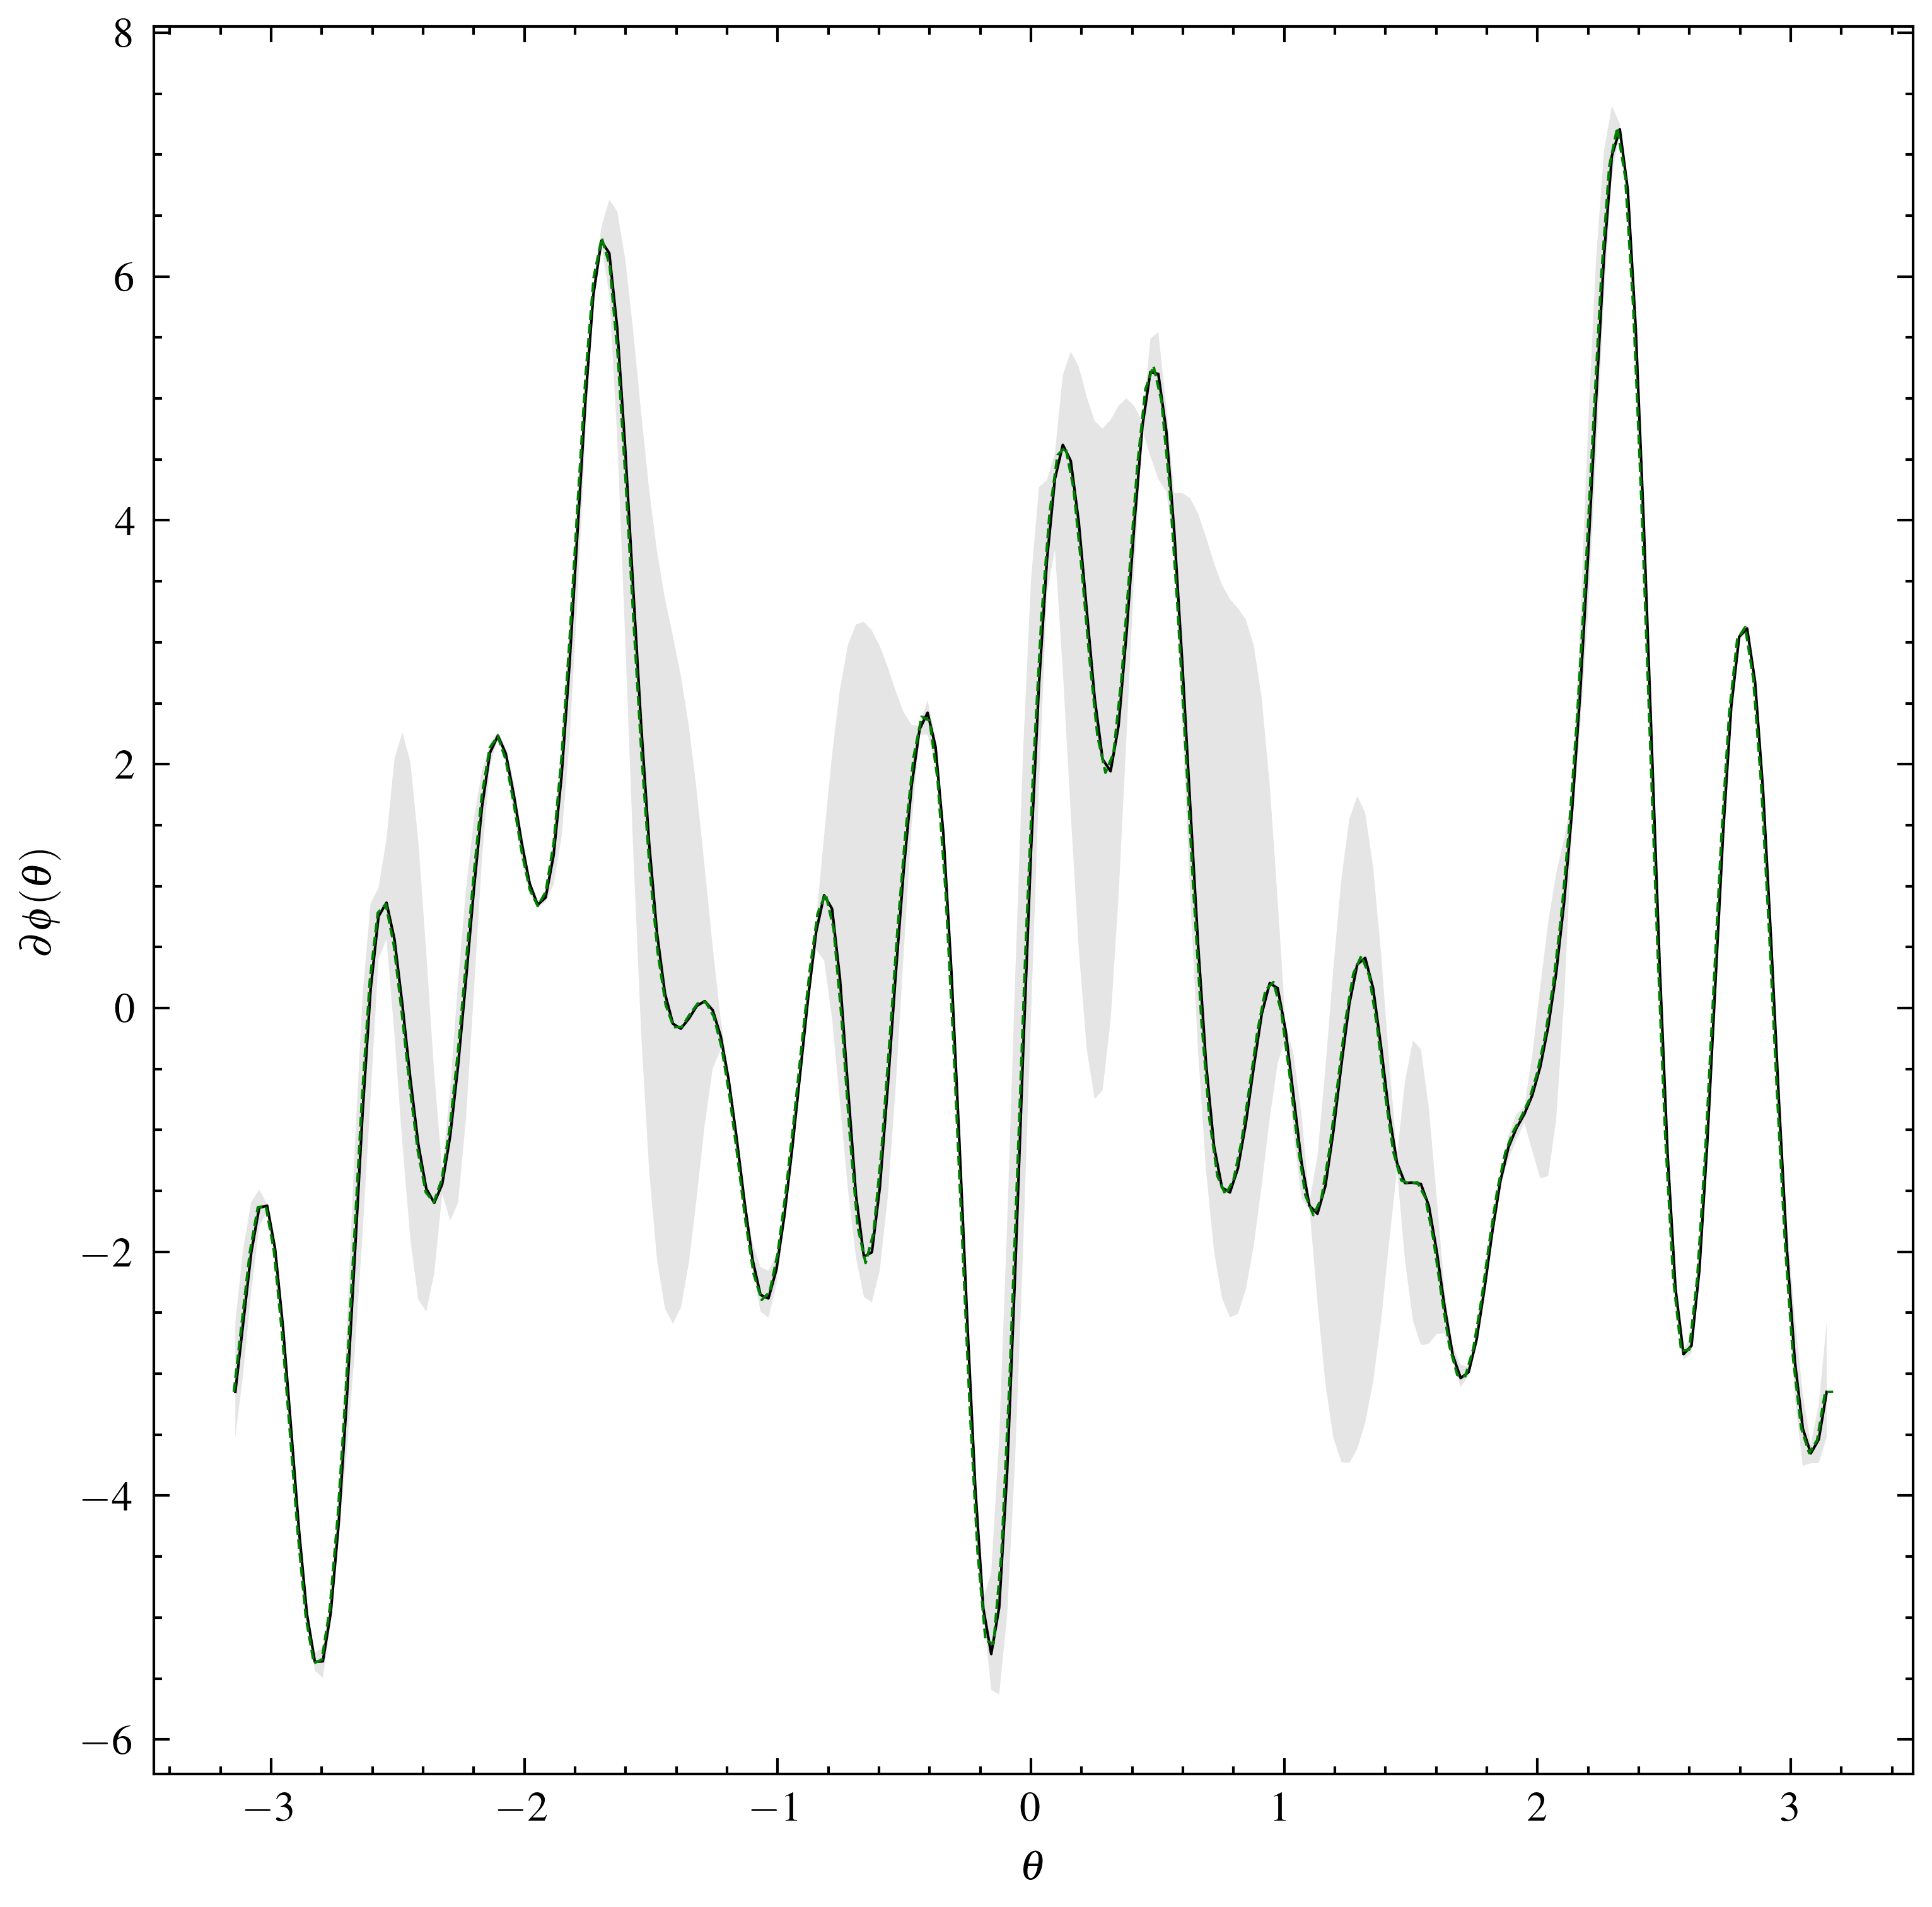

In [122]:
sample_dphi = total_potential(sample_coeffs, jnp.stack([dx, dy], axis=-1))

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 6))
    # plt.plot(theta_sampled, f, "o", markersize=2)
    # plt.plot(theta, dphi, color="grey", linewidth=0.5)
    plt.plot(theta, sample, "k-", linewidth=0.5)
    plt.fill_between(
        theta.ravel(),
        mean_prediction - 3 * std_prediction,
        mean_prediction + 3 * std_prediction,
        alpha=0.1,
        label=r"95% confidence interval",
    )
    plt.plot(theta * (1 + 1.0 / res) + 2.0 / res, sample_dphi, "g--", linewidth=0.5)

    plt.xlabel("$\\theta$")
    plt.ylabel("$\partial\phi(\\theta)$")
    plt.show()

## PyVista interactive plotting - unused

In [ ]:
import numpy as np
import pyvista as pv

# Create a PyVista mesh
# points = np.array(jnp.column_stack((dx, dy, dz)))
# spline = pv.Spline(points, 1000)
# spline.plot(render_lines_as_tubes=True, line_width=10)

# p = pv.Plotter(notebook=True)  # type: ignore
# p.add_mesh(spline, render_lines_as_tubes=True, line_width=10)
# p.show_bounds()
# p.show_axes()
# p.camera_position = "xz"
# p.show()